<h1>EDA and graph construction</h1>

In [32]:
import pandas as pd
import numpy as np
from datetime import datetime
import networkx as nx
from networkx.convert_matrix import from_pandas_edgelist
from networkx import DiGraph, Graph
from networkx.drawing.nx_pylab import draw_networkx_nodes
from networkx.algorithms.link_analysis.pagerank_alg import pagerank
import matplotlib.pyplot as plt
from networkx.algorithms.link_analysis.hits_alg import hits
from karateclub import Diff2Vec, DeepWalk
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from stellargraph import datasets
from IPython.display import display, HTML
from gensim.models import Word2Vec
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier

<b>Create start timestamp to calculate notebook runtime at bottom</b>

In [33]:
start = datetime.now()
print(start)

2021-07-05 20:36:35.078967


<b>Read in data for November 2019. We will sample this down further later on.</b>

In [34]:
df = pd.read_csv('../archive/2019-Nov.csv')

In [35]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [36]:
df.size

607517811

In [37]:
df.drop_duplicates().size

606613140

In [38]:
df = df.drop_duplicates()

In [39]:
df.count()

event_time       67401460
event_type       67401460
product_id       67401460
category_id      67401460
category_code    45530037
brand            58186451
price            67401460
user_id          67401460
user_session     67401450
dtype: int64

In [40]:
df.describe()

,product_id,category_id,price,user_id
count,6.740146e+07,6.740146e+07,6.740146e+07,6.740146e+07
mean,1.252092e+07,2.057901e+18,2.924819e+02,5.386307e+08
std,1.726199e+07,2.013233e+16,3.557358e+02,2.288443e+07
min,1.000365e+06,2.053014e+18,0.000000e+00,1.030022e+07
25%,1.305996e+06,2.053014e+18,6.924000e+01,5.164735e+08
50%,5.100571e+06,2.053014e+18,1.657700e+02,5.350394e+08
75%,1.730076e+07,2.053014e+18,3.603400e+02,5.610686e+08
max,1.000286e+08,2.187708e+18,2.574070e+03,5.799699e+08


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67401460 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 5.0+ GB


Drop null values and split category code into high-level and lower-leval category codes for use as node attributes

In [42]:
df = df.dropna()

In [43]:
def split_on_dot(stringy):
    return stringy.split('.')

df['event_time'] = pd.to_datetime(df['event_time'])
df['h_lvl'] = df['category_code'].apply(lambda x: split_on_dot(x)[0])
df['l_lvl'] = df['category_code'].apply(lambda x: split_on_dot(x)[1])

In [44]:
df.shape

(42018766, 11)

In [45]:
print(f'number unique category codes: {df.category_code.nunique()}')
print(f'number unique high level categories: {df.h_lvl.nunique()}')
print(f'number unique brands: {df.brand.nunique()}')
print(f'number unique event types: {df.event_type.nunique()}')
print(f'unique event types: {df.event_type.unique()}')
print(f'unique user ids: {df.user_id.nunique()}')
print(f'unique product ids: {df.product_id.nunique()}')

number unique category codes: 129
number unique high level categories: 13
number unique brands: 1987
number unique event types: 3
unique event types: ['view' 'cart' 'purchase']
unique user ids: 2862935
unique product ids: 69773


In [46]:
df['event_type'].value_counts()

view        39314217
cart         2045298
purchase      659251
Name: event_type, dtype: int64

In [47]:
df[df['user_session'] == '4d3b30da-a5e4-49df-b1a8-ba5943f1dd33']

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,h_lvl,l_lvl
0,2019-11-01 00:00:00+00:00,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,electronics,smartphone
95,2019-11-01 00:00:36+00:00,view,1004184,2053013555631882655,electronics.smartphone,xiaomi,463.15,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,electronics,smartphone
121,2019-11-01 00:00:47+00:00,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,electronics,smartphone
131,2019-11-01 00:00:50+00:00,view,1005234,2053013555631882655,electronics.smartphone,xiaomi,398.72,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,electronics,smartphone
263,2019-11-01 00:01:48+00:00,view,1003898,2053013555631882655,electronics.smartphone,oneplus,540.30,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,electronics,smartphone
329,2019-11-01 00:02:17+00:00,view,1003898,2053013555631882655,electronics.smartphone,oneplus,540.30,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,electronics,smartphone
352,2019-11-01 00:02:24+00:00,view,1003499,2053013555631882655,electronics.smartphone,oneplus,461.61,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,electronics,smartphone
397,2019-11-01 00:02:41+00:00,view,1003499,2053013555631882655,electronics.smartphone,oneplus,461.61,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,electronics,smartphone
416,2019-11-01 00:02:48+00:00,view,1003898,2053013555631882655,electronics.smartphone,oneplus,540.30,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,electronics,smartphone


Aggregate data into list of sequences for use in the creation of our graph database

In [48]:
df2 = df.groupby('user_id').agg(list)

In [49]:
df2.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_session,h_lvl,l_lvl
user_id,,,,,,,,,,
29515875,"[2019-11-10 02:14:40+00:00, 2019-11-12 03:45:0...","[view, view, view, view, view, view, view]","[13201002, 13200026, 1802034, 1802034, 1801638...","[2053013557192163841, 2053013557192163841, 205...","[furniture.bedroom.bed, furniture.bedroom.bed,...","[stendmebel, sv, kivi, kivi, harper, harper, h...","[176.04, 100.36, 115.04, 115.04, 153.67, 153.6...","[eb6882fb-ead2-47a5-aa86-d171a2c3b6ff, 643be73...","[furniture, furniture, electronics, electronic...","[bedroom, bedroom, video, video, video, video,..."
31198833,"[2019-11-08 02:09:45+00:00, 2019-11-08 02:10:3...","[view, view, view, view, view, view, view, vie...","[1005158, 1003551, 1005158, 1004870, 1004873, ...","[2053013555631882655, 2053013555631882655, 205...","[electronics.smartphone, electronics.smartphon...","[xiaomi, xiaomi, xiaomi, samsung, samsung, sam...","[302.45, 437.59, 302.45, 267.42, 360.07, 334.3...","[b9f5a88d-09a1-4327-a129-5e4425952f71, b9f5a88...","[electronics, electronics, electronics, electr...","[smartphone, smartphone, smartphone, smartphon..."
34916060,[2019-11-24 07:43:33+00:00],[view],[12600007],[2053013554751078769],[appliances.kitchen.grill],[tefal],[295.94],[4c2709a8-e61b-4d09-a0bf-b4d8b4923d00],[appliances],[kitchen]
41798457,[2019-11-26 08:33:16+00:00],[view],[100017960],[2053013555631882655],[electronics.smartphone],[huawei],[945.97],[7acfc025-a748-4dec-a2e0-5d4c54c8d8ca],[electronics],[smartphone]
62336140,"[2019-11-08 15:57:37+00:00, 2019-11-08 16:00:0...","[view, view, view, view, view, view]","[28718004, 28718694, 28720700, 28718348, 28718...","[2053013565639492569, 2053013565639492569, 205...","[apparel.shoes, apparel.shoes, apparel.shoes, ...","[respect, respect, respect, respect, respect, ...","[93.44, 89.84, 102.45, 84.43, 80.83, 124.84]","[393afdaf-b61d-4dda-87ff-b8467a4201fa, 393afda...","[apparel, apparel, apparel, apparel, apparel, ...","[shoes, shoes, shoes, shoes, shoes, shoes]"


In [50]:
df2.shape

(2862935, 10)

<h2>Create training and validation sets</h2>
Training data will be split into training and test sets and will build the graph from which embeddings are created. Validation data will be kept separate from the training of graph embeddings and serve as completely unseen data for predicting future events.

In [84]:
df2_sample = df2.sample(frac=0.2, random_state=42)
df2_sample['seq_num'] = df2_sample['event_type'].apply(lambda x: len(x))
df2_sample = df2_sample[df2_sample.seq_num > 6]


training_data, validation_data = train_test_split(df2_sample, test_size=0.3, random_state=42)

In [85]:
# distinct_product_ids = []
# for i in range(len(training_data)):
#     for j in training_data.iloc[i]['product_id']:
#         if j in distinct_product_ids:
#             pass
#         else:
#             distinct_product_ids.append(j)
            
            
distinct_h_lvl_ids = []
for i in range(len(training_data)):
    for j in training_data.iloc[i]['h_lvl']:
        if j in distinct_h_lvl_ids:
            pass
        else:
            distinct_h_lvl_ids.append(j)

In [86]:
# len(distinct_product_ids)

In [87]:
# product_map= \
# {distinct_product_ids[i]:[x for x in range(0,len(distinct_product_ids))][i] for i in range(len(distinct_product_ids))}

h_lvl_map= \
{distinct_h_lvl_ids[i]:[x for x in range(0,len(distinct_h_lvl_ids))][i] for i in range(len(distinct_h_lvl_ids))}

In [88]:
h_lvl_map

{'electronics': 0,
 'apparel': 1,
 'computers': 2,
 'appliances': 3,
 'furniture': 4,
 'auto': 5,
 'accessories': 6,
 'sport': 7,
 'construction': 8,
 'kids': 9,
 'stationery': 10,
 'medicine': 11,
 'country_yard': 12}

In [89]:
training_data.shape

(171245, 11)

Define function to convert time sequences into length of time between one event and another as possible edge weights

In [90]:
def time_list(listy):
    new_listy = []
    for i, j in enumerate(listy):
        if i == 0:
            pass
        else:
            new_listy.append((j-(listy[i-1])).total_seconds())
    return new_listy

In [91]:
time_list(training_data.iloc[1]['event_time'])[0:3]

[129.0, 44.0, 22.0]

In [92]:
(training_data.iloc[1]['event_time'][1] - training_data.iloc[1]['event_time'][0]).total_seconds()

129.0

In [93]:
def last_char(listy):
    return listy[-1]

def return_all_but_last(listy):
    return listy[:-1]

In [94]:
training_data.head(2)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_session,h_lvl,l_lvl,seq_num
user_id,,,,,,,,,,,
567069554,"[2019-11-08 09:42:27+00:00, 2019-11-08 09:42:4...","[view, view, view, view, view, view, view, car...","[1005115, 1005115, 1004249, 1004249, 1004250, ...","[2053013555631882655, 2053013555631882655, 205...","[electronics.smartphone, electronics.smartphon...","[apple, apple, apple, apple, apple, apple, app...","[915.08, 915.08, 739.79, 739.79, 814.56, 814.5...","[629faf75-5107-41d6-9806-123eb20676f9, 629faf7...","[electronics, electronics, electronics, electr...","[smartphone, smartphone, smartphone, smartphon...",32
559077481,"[2019-11-12 07:48:18+00:00, 2019-11-12 07:50:2...","[view, view, view, view, view, view, cart, pur...","[4804660, 28721804, 28717827, 28703606, 287177...","[2053013554658804075, 2053013565069067197, 205...","[electronics.audio.headphone, apparel.shoes.ke...","[xiaomi, adidas, adidas, reebok, puma, reebok,...","[23.09, 102.71, 102.71, 118.15, 84.69, 118.15,...","[2fedbf73-0fcd-4c54-95b7-0fd85cb17d67, 2fedbf7...","[electronics, apparel, apparel, apparel, appar...","[audio, shoes, shoes, shoes, shoes, shoes, sho...",11


<h2>Feature engineering function</h2>

In [95]:
def feature_engineer(df):    
    df['time_between'] = ''

    df['next_event'] = df['event_type'].apply(lambda x: last_char(x))
#     df['next_product_id'] = df['product_id'].apply(lambda x: last_char(x))
    df['next_time_between'] = df['product_id'].apply(lambda x: last_char(x))
    # df['time_on_page'] = df['event_type'].apply(lambda x: time_list(x))

    for i in range(len(df)):
    #     if i % 50000 == 0:
    #         print(i)
        df['time_between'].iloc[i] = time_list(df.iloc[i]['event_time'])

    #create RML (remove last) columns in which the last event from each sequence has been removed    
    df['rml_event_time'] = df['event_time'].apply(lambda x: return_all_but_last(x))
    df['rml_event_type'] = df['event_type'].apply(lambda x: return_all_but_last(x))
#     df['rml_product_id'] = df['product_id'].apply(lambda x: return_all_but_last(x))
    df['rml_category_id'] = df['category_id'].apply(lambda x: return_all_but_last(x))
    df['rml_category_code'] = df['category_code'].apply(lambda x: return_all_but_last(x))
    df['rml_brand'] = df['price'].apply(lambda x: return_all_but_last(x))
    df['rml_user_session'] = df['user_session'].apply(lambda x: return_all_but_last(x))
    df['rml_event_time'] = df['event_time'].apply(lambda x: return_all_but_last(x))
    df['rml_h_lvl'] = df['h_lvl'].apply(lambda x: return_all_but_last(x))
    df['rml_l_lvl'] = df['l_lvl'].apply(lambda x: return_all_but_last(x))
    df['rml_time_between'] = df['time_between'].apply(lambda x: return_all_but_last(x))


    def map_values(listy, label_map):
        listy2 = []
        for i in listy:
            listy2.append(int(label_map[i]))
        return listy2

#     df['product_id_new_labels'] = df['product_id'].apply(lambda x: map_values(x, product_map))
    df['h_lvl_id_new_labels'] = df['h_lvl'].apply(lambda x: map_values(x, h_lvl_map))
    df['next_h_lvl'] = df['h_lvl_id_new_labels'].apply(lambda x: last_char(x))
    df['rml_h_lvl_id_new_labels'] = df['h_lvl_id_new_labels'].apply(lambda x: return_all_but_last(x))
    
    return df
    
    
training_data = feature_engineer(training_data)
validation_data = feature_engineer(validation_data)

<ipython-input-95-00943c5b9fa6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_between'] = ''
<ipython-input-95-00943c5b9fa6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['next_event'] = df['event_type'].apply(lambda x: last_char(x))
<ipython-input-95-00943c5b9fa6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [96]:
training_data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_session,h_lvl,l_lvl,...,rml_category_id,rml_category_code,rml_brand,rml_user_session,rml_h_lvl,rml_l_lvl,rml_time_between,h_lvl_id_new_labels,next_h_lvl,rml_h_lvl_id_new_labels
user_id,,,,,,,,,,,,,,,,,,,,,
567069554,"[2019-11-08 09:42:27+00:00, 2019-11-08 09:42:4...","[view, view, view, view, view, view, view, car...","[1005115, 1005115, 1004249, 1004249, 1004250, ...","[2053013555631882655, 2053013555631882655, 205...","[electronics.smartphone, electronics.smartphon...","[apple, apple, apple, apple, apple, apple, app...","[915.08, 915.08, 739.79, 739.79, 814.56, 814.5...","[629faf75-5107-41d6-9806-123eb20676f9, 629faf7...","[electronics, electronics, electronics, electr...","[smartphone, smartphone, smartphone, smartphon...",...,"[2053013555631882655, 2053013555631882655, 205...","[electronics.smartphone, electronics.smartphon...","[915.08, 915.08, 739.79, 739.79, 814.56, 814.5...","[629faf75-5107-41d6-9806-123eb20676f9, 629faf7...","[electronics, electronics, electronics, electr...","[smartphone, smartphone, smartphone, smartphon...","[14.0, 30.0, 8.0, 11.0, 10.0, 10.0, 8.0, 6.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
559077481,"[2019-11-12 07:48:18+00:00, 2019-11-12 07:50:2...","[view, view, view, view, view, view, cart, pur...","[4804660, 28721804, 28717827, 28703606, 287177...","[2053013554658804075, 2053013565069067197, 205...","[electronics.audio.headphone, apparel.shoes.ke...","[xiaomi, adidas, adidas, reebok, puma, reebok,...","[23.09, 102.71, 102.71, 118.15, 84.69, 118.15,...","[2fedbf73-0fcd-4c54-95b7-0fd85cb17d67, 2fedbf7...","[electronics, apparel, apparel, apparel, appar...","[audio, shoes, shoes, shoes, shoes, shoes, sho...",...,"[2053013554658804075, 2053013565069067197, 205...","[electronics.audio.headphone, apparel.shoes.ke...","[23.09, 102.71, 102.71, 118.15, 84.69, 118.15,...","[2fedbf73-0fcd-4c54-95b7-0fd85cb17d67, 2fedbf7...","[electronics, apparel, apparel, apparel, appar...","[audio, shoes, shoes, shoes, shoes, shoes, sho...","[129.0, 44.0, 22.0, 77.0, 23.0, 30.0, 137.0, 3...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
513711707,"[2019-11-13 10:32:21+00:00, 2019-11-15 10:04:2...","[view, view, view, view, view, view, view, view]","[1005284, 1801766, 1801631, 1801631, 1801785, ...","[2053013555631882655, 2053013554415534427, 205...","[electronics.smartphone, electronics.video.tv,...","[samsung, artel, artel, artel, lg, apacer, apa...","[2562.49, 154.19, 334.11, 334.11, 447.63, 33.2...","[88c7c83c-e255-49ed-b707-f73c7d737e88, 2168a15...","[electronics, electronics, electronics, electr...","[smartphone, video, video, video, video, compo...",...,"[2053013555631882655, 2053013554415534427, 205...","[electronics.smartphone, electronics.video.tv,...","[2562.49, 154.19, 334.11, 334.11, 447.63, 33.2...","[88c7c83c-e255-49ed-b707-f73c7d737e88, 2168a15...","[electronics, electronics, electronics, electr...","[smartphone, video, video, video, video, compo...","[171121.0, 5863.0, 33.0, 294.0, 138645.0, 20.0]","[0, 0, 0, 0, 0, 2, 2, 0]",0,"[0, 0, 0, 0, 0, 2, 2]"
523379089,"[2019-11-02 17:05:40+00:00, 2019-11-02 17:06:4...","[view, view, view, view, view, view, view, vie...","[28719634, 28717035, 28715765, 28719086, 28714...","[2053013565069067197, 2053013565069067197, 205...","[apparel.shoes.keds, apparel.shoes.keds, appar...","[fassen, strobbs, nexpero, fassen, nike, nike,...","[44.79, 48.39, 75.42, 44.79, 55.39, 55.39, 44....","[69cfd1b9-ea8a-4fb6-bc10-caae9928ad4c, 69cfd1b...","[apparel, apparel, apparel, apparel, apparel, ...","[shoes, shoes, shoes, shoes, shoes, shoes, sho...",...,"[2053013565069067197, 2053013565069067197, 205...","[apparel.shoes.keds, apparel.shoes.keds, appar...","[44.79, 48.39, 75.42, 44.79, 55.39, 55.39, 44....","[69cfd1b9-ea8a-4fb6-bc10-caae9928ad4c, 69cfd1b...","[apparel, apparel, apparel, apparel, apparel, ...","[

In [97]:
# training_data.to_csv('sample.csv', index=False)
# table = pa.Table.from_pandas(training_data)
# pq.write_to_dataset(table, 'sample.parquet')

Functions for creating graphs only by user_id (for graph2vec)

In [98]:
def edge_maker_sm(df, iloc_num, node_category):
    product_id_list = df.iloc[iloc_num][node_category]
    time_on_page = df.iloc[iloc_num]['time_between']
#     event_type = df.iloc[iloc_num]['event_type']
#     source_target_dict = {'source':[], 'target':[], 'weight':[0] + time_on_page, 'attributes':event_type}
    source_target_dict = {'source':[], 'target':[], 'weight':time_on_page, 'event_type':[]}
    
    for i, j in enumerate(product_id_list):
        if i == 0:
#             source_target_dict['source'].append(f'customer_{iloc_num}')
#             source_target_dict['target'].append(f'{product_id_list[i+1]}')
            pass
        else:
            source_target_dict['source'].append(f'{product_id_list[i-1]}')
            source_target_dict['target'].append(f'{j}')
            source_target_dict['event_type'].append(df.iloc[iloc_num]['event_type'][i])
    return source_target_dict
  

def node_maker_sm(df, iloc_num, node_category):
    node_category = df.iloc[iloc_num][node_category]
#     time_on_page = df.iloc[iloc_num]['category_id']
#     h_lvl = df.iloc[iloc_num]['h_lvl']
#     l_lvl = df.iloc[iloc_num]['l_lvl']
#     user_session = df.iloc[iloc_num]['user_session']
    
    distinct_node_categories = [str(i) for n, i in enumerate(node_category) if i not in node_category[:n]]
#     distinct_category_ids = [i for n, i in enumerate(category_id) if i not in category_id[:n]]
#     distinct_h_lvls = [i for n, i in enumerate(h_lvl) if i not in h_lvl[:n]]
#     distinct_l_lvls = [i for n, i in enumerate(l_lvl) if i not in l_lvl[:n]]
#     distinct_user_sessions = [i for n, i in enumerate(user_session) if i not in user_session[:n]]
    
#     node_dict = {'id':[f'customer_{iloc_num}'] + distinct_product_ids}
    node_dict = {'id':distinct_product_ids}
    return node_dict

In [99]:
edge_maker_sm(training_data, 1, 'l_lvl')

{'source': ['audio',
  'shoes',
  'shoes',
  'shoes',
  'shoes',
  'shoes',
  'shoes',
  'shoes',
  'shoes',
  'shoes'],
 'target': ['shoes',
  'shoes',
  'shoes',
  'shoes',
  'shoes',
  'shoes',
  'shoes',
  'shoes',
  'shoes',
  'shoes'],
 'weight': [129.0,
  44.0,
  22.0,
  77.0,
  23.0,
  30.0,
  137.0,
  370.0,
  217.0,
  967902.0],
 'event_type': ['view',
  'view',
  'view',
  'view',
  'view',
  'cart',
  'purchase',
  'view',
  'view',
  'view']}

In [100]:
def edge_maker(df, node_category):
    source_target_dict = {'source':[], 'target':[], 'weight':[], 'event_type':[]}
    for x in range(len(df)):
        product_id_list = df.iloc[x][node_category]
        for q in df.iloc[x]['time_between']:
            source_target_dict['weight'].append(q)
    #     source_target_dict = {'source':[], 'target':[], 'weight':[0] + time_on_page, 'attributes':event_type}
        
        for i, j in enumerate(product_id_list):
            if i == 0:
    #             source_target_dict['source'].append(f'customer_{iloc_num}')
    #             source_target_dict['target'].append(f'{product_id_list[i+1]}')
                pass
            else:
                source_target_dict['source'].append(f'{product_id_list[i-1]}')
                source_target_dict['target'].append(f'{j}')
                source_target_dict['event_type'].append(df.iloc[x]['event_type'][i])
    return source_target_dict


def node_maker(df):
    product_id = df.iloc[iloc_num]['product_id']
#     time_on_page = df.iloc[iloc_num]['category_id']
#     h_lvl = df.iloc[iloc_num]['h_lvl']
#     l_lvl = df.iloc[iloc_num]['l_lvl']
#     user_session = df.iloc[iloc_num]['user_session']
    
    distinct_product_ids = [str(i) for n, i in enumerate(product_id) if i not in product_id[:n]]
#     distinct_category_ids = [i for n, i in enumerate(category_id) if i not in category_id[:n]]
#     distinct_h_lvls = [i for n, i in enumerate(h_lvl) if i not in h_lvl[:n]]
#     distinct_l_lvls = [i for n, i in enumerate(l_lvl) if i not in l_lvl[:n]]
#     distinct_user_sessions = [i for n, i in enumerate(user_session) if i not in user_session[:n]]
    
#     node_dict = {'id':[f'customer_{iloc_num}'] + distinct_product_ids}
    node_dict = {'id':distinct_product_ids}
    return node_dict

In [101]:
ex_dict = edge_maker(training_data, 'h_lvl_id_new_labels')

In [102]:
len(ex_dict['source'])

5131363

In [103]:
len(ex_dict['target'])

5131363

In [104]:
len(ex_dict['weight'])

5131363

In [105]:
len(ex_dict['event_type'])

5131363

In [106]:
edges = pd.DataFrame(edge_maker(training_data, 'h_lvl_id_new_labels'))
edges

,source,target,weight,event_type
0,0,0,14.0,view
1,0,0,30.0,view
2,0,0,8.0,view
3,0,0,11.0,view
4,0,0,10.0,view
...,...,...,...,...
5131358,0,0,247386.0,view
5131359,0,0,74.0,view
5131360,0,0,32.0,view
5131361,0,0,345713.0,view


In [107]:
# nodes = pd.DataFrame(node_maker(1), index=[node_maker(1)['id']]).drop(['id'], axis=1)
# nodes

In [108]:
DG = DiGraph(from_pandas_edgelist(edges))
G = Graph(from_pandas_edgelist(edges))

<b>The below numbers must match.</b>

In [109]:
print(len(distinct_h_lvl_ids))
print(len(DG.nodes))

13
13


In [110]:
len(DG.edges)

165

In [111]:
# nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G))

In [112]:
# nodes

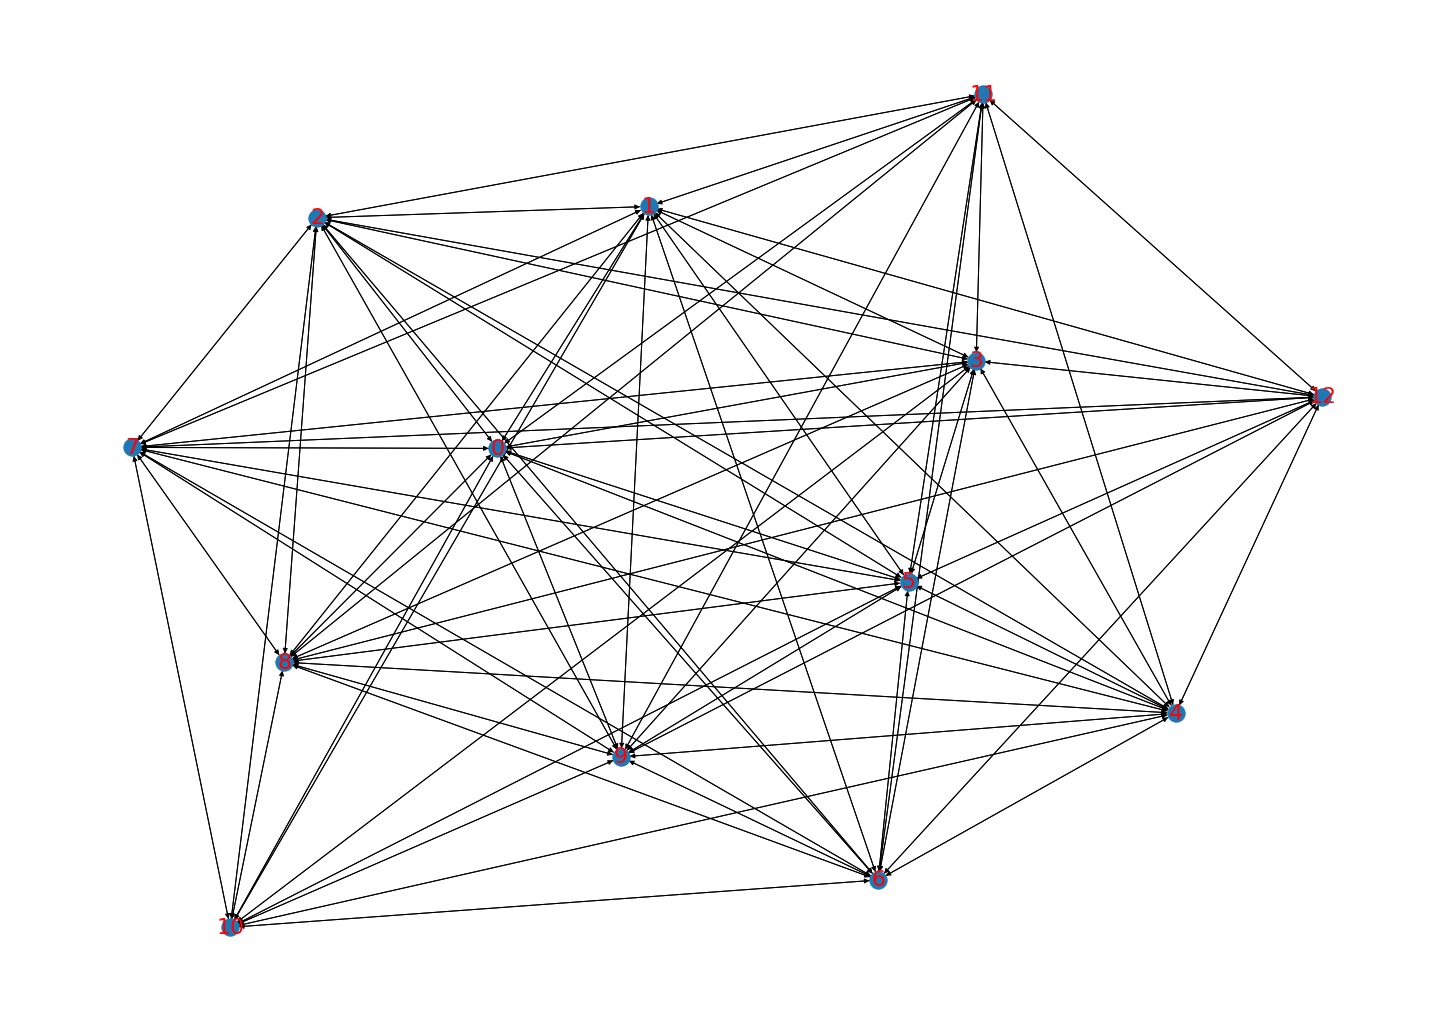

In [113]:
plt.figure(figsize=(20, 14))
nx.draw(DG, with_labels = True, font_size=22, font_color="red")

PageRank (PR) is an algorithm used by Google Search to rank web pages in their search engine results. PageRank is a way of measuring the importance of website pages. According to Google: PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites. (Wikipedia)

In [114]:
pagerank(DG)

{'0': 0.07853169195416693,
 '1': 0.07853169195416693,
 '2': 0.07853169195416693,
 '3': 0.07853169195416693,
 '4': 0.07853169195416693,
 '5': 0.07853169195416693,
 '6': 0.07853169195416693,
 '7': 0.07853169195416693,
 '8': 0.07853169195416693,
 '9': 0.07853169195416693,
 '10': 0.0681524233217771,
 '11': 0.07326532856827686,
 '12': 0.07326532856827686}

Hyperlink-Induced Topic Search (HITS; also known as hubs and authorities) is a link analysis algorithm that rates Web pages, developed by Jon Kleinberg. The idea behind Hubs and Authorities stemmed from a particular insight into the creation of web pages when the Internet was originally forming; that is, certain web pages, known as hubs, served as large directories that were not actually authoritative in the information that they held, but were used as compilations of a broad catalog of information that led users direct to other authoritative pages. In other words, a good hub represents a page that pointed to many other pages, while a good authority represents a page that is linked by many different hubs. (Wikipedia)

In [115]:
hits(DG)

({'0': 0.0786217359301286,
  '1': 0.0786217359301286,
  '2': 0.0786217359301286,
  '3': 0.0786217359301286,
  '4': 0.0786217359301286,
  '5': 0.07862173593012858,
  '6': 0.07862173593012858,
  '7': 0.0786217359301286,
  '8': 0.07862173593012858,
  '9': 0.07862173593012858,
  '10': 0.06708837837613495,
  '11': 0.07334713116128953,
  '12': 0.07334713116128953},
 {'0': 0.0786217359309263,
  '1': 0.0786217359309263,
  '2': 0.0786217359309263,
  '3': 0.0786217359309263,
  '4': 0.0786217359309263,
  '5': 0.0786217359309263,
  '6': 0.0786217359309263,
  '7': 0.0786217359309263,
  '8': 0.0786217359309263,
  '9': 0.0786217359309263,
  '10': 0.0670883783782974,
  '11': 0.07334713115621978,
  '12': 0.07334713115621978})

In [116]:
training_data.shape

(171245, 26)

In [117]:
training_data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_session,h_lvl,l_lvl,...,rml_category_id,rml_category_code,rml_brand,rml_user_session,rml_h_lvl,rml_l_lvl,rml_time_between,h_lvl_id_new_labels,next_h_lvl,rml_h_lvl_id_new_labels
user_id,,,,,,,,,,,,,,,,,,,,,
567069554,"[2019-11-08 09:42:27+00:00, 2019-11-08 09:42:4...","[view, view, view, view, view, view, view, car...","[1005115, 1005115, 1004249, 1004249, 1004250, ...","[2053013555631882655, 2053013555631882655, 205...","[electronics.smartphone, electronics.smartphon...","[apple, apple, apple, apple, apple, apple, app...","[915.08, 915.08, 739.79, 739.79, 814.56, 814.5...","[629faf75-5107-41d6-9806-123eb20676f9, 629faf7...","[electronics, electronics, electronics, electr...","[smartphone, smartphone, smartphone, smartphon...",...,"[2053013555631882655, 2053013555631882655, 205...","[electronics.smartphone, electronics.smartphon...","[915.08, 915.08, 739.79, 739.79, 814.56, 814.5...","[629faf75-5107-41d6-9806-123eb20676f9, 629faf7...","[electronics, electronics, electronics, electr...","[smartphone, smartphone, smartphone, smartphon...","[14.0, 30.0, 8.0, 11.0, 10.0, 10.0, 8.0, 6.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
559077481,"[2019-11-12 07:48:18+00:00, 2019-11-12 07:50:2...","[view, view, view, view, view, view, cart, pur...","[4804660, 28721804, 28717827, 28703606, 287177...","[2053013554658804075, 2053013565069067197, 205...","[electronics.audio.headphone, apparel.shoes.ke...","[xiaomi, adidas, adidas, reebok, puma, reebok,...","[23.09, 102.71, 102.71, 118.15, 84.69, 118.15,...","[2fedbf73-0fcd-4c54-95b7-0fd85cb17d67, 2fedbf7...","[electronics, apparel, apparel, apparel, appar...","[audio, shoes, shoes, shoes, shoes, shoes, sho...",...,"[2053013554658804075, 2053013565069067197, 205...","[electronics.audio.headphone, apparel.shoes.ke...","[23.09, 102.71, 102.71, 118.15, 84.69, 118.15,...","[2fedbf73-0fcd-4c54-95b7-0fd85cb17d67, 2fedbf7...","[electronics, apparel, apparel, apparel, appar...","[audio, shoes, shoes, shoes, shoes, shoes, sho...","[129.0, 44.0, 22.0, 77.0, 23.0, 30.0, 137.0, 3...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
513711707,"[2019-11-13 10:32:21+00:00, 2019-11-15 10:04:2...","[view, view, view, view, view, view, view, view]","[1005284, 1801766, 1801631, 1801631, 1801785, ...","[2053013555631882655, 2053013554415534427, 205...","[electronics.smartphone, electronics.video.tv,...","[samsung, artel, artel, artel, lg, apacer, apa...","[2562.49, 154.19, 334.11, 334.11, 447.63, 33.2...","[88c7c83c-e255-49ed-b707-f73c7d737e88, 2168a15...","[electronics, electronics, electronics, electr...","[smartphone, video, video, video, video, compo...",...,"[2053013555631882655, 2053013554415534427, 205...","[electronics.smartphone, electronics.video.tv,...","[2562.49, 154.19, 334.11, 334.11, 447.63, 33.2...","[88c7c83c-e255-49ed-b707-f73c7d737e88, 2168a15...","[electronics, electronics, electronics, electr...","[smartphone, video, video, video, video, compo...","[171121.0, 5863.0, 33.0, 294.0, 138645.0, 20.0]","[0, 0, 0, 0, 0, 2, 2, 0]",0,"[0, 0, 0, 0, 0, 2, 2]"
523379089,"[2019-11-02 17:05:40+00:00, 2019-11-02 17:06:4...","[view, view, view, view, view, view, view, vie...","[28719634, 28717035, 28715765, 28719086, 28714...","[2053013565069067197, 2053013565069067197, 205...","[apparel.shoes.keds, apparel.shoes.keds, appar...","[fassen, strobbs, nexpero, fassen, nike, nike,...","[44.79, 48.39, 75.42, 44.79, 55.39, 55.39, 44....","[69cfd1b9-ea8a-4fb6-bc10-caae9928ad4c, 69cfd1b...","[apparel, apparel, apparel, apparel, apparel, ...","[shoes, shoes, shoes, shoes, shoes, shoes, sho...",...,"[2053013565069067197, 2053013565069067197, 205...","[apparel.shoes.keds, apparel.shoes.keds, appar...","[44.79, 48.39, 75.42, 44.79, 55.39, 55.39, 44....","[69cfd1b9-ea8a-4fb6-bc10-caae9928ad4c, 69cfd1b...","[apparel, apparel, apparel, apparel, apparel, ...","[

<b>Weighted walks provided more balanced training and testing scores. Weighted=False created slight underfitting.</b>

In [118]:
G = StellarGraph.from_networkx(G)
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # indicates the walks are weighted
    seed=42  # seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 130


In [119]:
str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks)

# The embedding vectors can be retrieved from model.wv using the node ID as key.
model.wv["12"].shape

(100,)

In [120]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)

In [121]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
# the gensim ordering may not match the StellarGraph one, so rearrange
node_targets = G.nodes

In [122]:
len(node_embeddings)

13

In [123]:
node_embeddings[0]

array([-0.13862722,  0.09046573,  0.12637694,  0.0824123 ,  0.00568685,
       -0.12697719,  0.1351505 ,  0.39290622, -0.26613393, -0.28391597,
        0.11563054, -0.1550235 , -0.05522674, -0.07463357,  0.06784345,
       -0.12004858,  0.16536303, -0.0355355 , -0.15420866, -0.48615178,
       -0.10937128, -0.05889551,  0.43389273, -0.05077783, -0.09357399,
        0.02117249, -0.1765107 ,  0.26357928, -0.1567845 ,  0.16205513,
        0.14092825, -0.12920903,  0.09513952, -0.08413444, -0.08492308,
        0.11246099,  0.07550357, -0.01309837, -0.11219599, -0.0258582 ,
        0.08541229,  0.0104368 , -0.27654144,  0.0943004 ,  0.02959536,
       -0.1352065 ,  0.06082956,  0.03483504, -0.05280661,  0.15227386,
        0.08998896, -0.1707148 ,  0.01950506, -0.06427126, -0.17601345,
       -0.18658619, -0.08410882, -0.09331952,  0.07642787, -0.04125725,
       -0.08385718, -0.09998909,  0.41166136, -0.08779138, -0.29036778,
        0.22166856,  0.09254262,  0.20328905, -0.37863377, -0.04

In [124]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

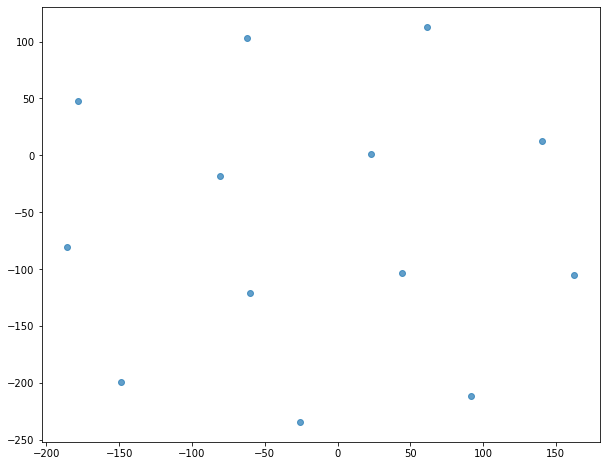

In [125]:
# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    cmap="jet",
    alpha=0.7,
)
plt.show()

In [126]:
ex_df = pd.DataFrame({'col1':[1,1,1,1], 'col2':[2,2,2,2], 'col3':[3,3,3,3]})

In [127]:
ex_df.head()

,col1,col2,col3
0,1,2,3
1,1,2,3
2,1,2,3
3,1,2,3


In [128]:
ex_df.to_numpy()

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]], dtype=int64)

In [129]:
np.vstack((node_embeddings[0][0:3],node_embeddings[1][0:3]))

array([[-0.13862722,  0.09046573,  0.12637694],
       [-0.14946161,  0.09611302,  0.12758557]], dtype=float32)

In [130]:
# for i in xrange(10):
#     c = np.vstack((c, np.random.randint(0, 10, 10)))



In [131]:
np.append(node_embeddings[0][0:3], node_embeddings[1][0:3])

array([-0.13862722,  0.09046573,  0.12637694, -0.14946161,  0.09611302,
        0.12758557], dtype=float32)

In [132]:
training_data['seq_num'].max()

8828

In [133]:
training_data['seq_num'].min()

7

In [134]:
training_data['seq_num'].mean()

30.965038395281614

In [135]:
training_data['seq_num'].median()

17.0

<AxesSubplot:>

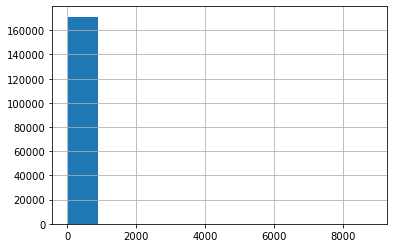

In [136]:
training_data['seq_num'].hist()

In [137]:
training_data.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_session', 'h_lvl', 'l_lvl',
       'seq_num', 'time_between', 'next_event', 'next_time_between',
       'rml_event_time', 'rml_event_type', 'rml_category_id',
       'rml_category_code', 'rml_brand', 'rml_user_session', 'rml_h_lvl',
       'rml_l_lvl', 'rml_time_between', 'h_lvl_id_new_labels', 'next_h_lvl',
       'rml_h_lvl_id_new_labels'],
      dtype='object')

In [138]:
training_data['next_h_lvl']

user_id
567069554    0
559077481    1
513711707    0
523379089    3
515367279    4
            ..
537743713    0
557942983    5
523710672    0
546149900    0
513326433    0
Name: next_h_lvl, Length: 171245, dtype: int64

In [140]:
cart_sample = training_data[training_data['next_event'] == 'cart']
sample_min = cart_sample.shape[0]

purchase_sample = training_data[training_data['next_event'] == 'purchase'].sample(sample_min)
view_sample = training_data[training_data['next_event'] == 'view'].sample(sample_min)

In [142]:
#now for validation data set
val_cart_sample = validation_data[validation_data['next_event'] == 'cart']
val_sample_min = val_cart_sample.shape[0]

val_purchase_sample = validation_data[validation_data['next_event'] == 'purchase'].sample(val_sample_min)
val_view_sample = validation_data[validation_data['next_event'] == 'view'].sample(val_sample_min)

In [143]:
cart_sample.shape[0]

6421

In [144]:
model_sample = purchase_sample.append(cart_sample).append(view_sample).reset_index()
validation_set = val_purchase_sample.append(val_cart_sample).append(val_view_sample).reset_index()

In [145]:
model_sample.shape

(19263, 27)

In [146]:
y = model_sample['next_event']
y_val = validation_set['next_event']

In [147]:
# def sequence_lookback_embedding_concat(embedding_list, sequence, num_lookback):
#     array = np.nan
#     for i in range(1,num_lookback+1):
#         if i == 1:
#             array = embedding_list[sequence[-i]]
#         else:
#             array = np.append(array, embedding_list[sequence[-i]])
#             print(i)
#     return array


# for i in range(len(model_sample)):
#     if i == 0:
#         array = node_embeddings[model_sample.iloc[i]['next_h_lvl']]
#     else:
#         array = np.vstack((array,node_embeddings[model_sample.iloc[i]['next_h_lvl']]))
                          
# X = pd.DataFrame(array)

In [148]:
#Fix try except statement...it breaks when there are num_lookback beyond minimum (3)


def sequence_lookback_embedding_concat(embedding_list, sequence, num_lookback):
    array = np.nan
    for i in range(1,num_lookback+1):
        if i == 1:
            array = embedding_list[sequence[-i]]
        else:
            try:
                array = np.append(array, embedding_list[sequence[-i]])
            except IndexError:
                array = np.append(array, embedding_list[sequence[0]])
    return array

def multi_embedding_df(df, node_embeddings, sequence_col, num_lookback):
    for i in range(len(df)):
        if i == 0:
            array = sequence_lookback_embedding_concat(node_embeddings, df.iloc[0][sequence_col], num_lookback)
        else:
            array = np.vstack((array, sequence_lookback_embedding_concat(node_embeddings, 
                                                                         df.iloc[i][sequence_col], num_lookback)))
    return array

In [149]:
len(sequence_lookback_embedding_concat(node_embeddings, model_sample.iloc[0]['h_lvl_id_new_labels'], 7))

700

In [150]:
X = multi_embedding_df(model_sample, node_embeddings, 'h_lvl_id_new_labels',7)
X_val = multi_embedding_df(validation_set, node_embeddings, 'h_lvl_id_new_labels',7)  

In [151]:
len(X)

19263

In [152]:
# vstacked_array = np.nan
# for i in range(len(model_sample)):
#     array = np.nan
#     for j, k in enumerate(model_sample.iloc[i]['rml_event_type']):
#         if j == 0:
#             if j == 'view':
#                 array = np.array([1,0,0])
#             elif j == 'purchase':
#                 array = np.array([0,1,0])
#             else:
#                 array = np.array([0,0,1])
#         elif j != 0:
#             if j == 'view':
#                 array = np.append(array, np.array([1,0,0]))
#             elif j == 'purchase':
#                 array = np.append(array, np.array([0,1,0]))
#             else:
#                 array = np.append(array, np.array([0,0,1]))
#     if i == 0:
#         vstacked_array = array
#     else:
#         vstacked_array = np.vstack((vstacked_array, array)) 

In [153]:
def one_hot_sequence(df, column, num_lookback):
    stacked_listy = []
    for i in range(len(df)):
        one_hot_listy = []
        for j in range(1,num_lookback+1):
            if df.iloc[i][column][-j] == 'view':
                one_hot_listy.append(1)
                one_hot_listy.append(0)
                one_hot_listy.append(0)
            elif df.iloc[i][column][-j] == 'purchase':
                one_hot_listy.append(0)
                one_hot_listy.append(1)
                one_hot_listy.append(0)
            elif df.iloc[i][column][-j] == 'cart':
                one_hot_listy.append(0)
                one_hot_listy.append(0)
                one_hot_listy.append(1)
        stacked_listy.append(one_hot_listy)

    return stacked_listy

In [154]:
X2 = one_hot_sequence(model_sample, 'rml_event_type', 6)
X2_val = one_hot_sequence(validation_set, 'rml_event_type', 6)

In [155]:
X3 = np.append(np.array(X), np.array(X2), axis=1)
X3_val = np.append(np.array(X_val), np.array(X2_val), axis=1)

In [156]:
X3.shape

(19263, 718)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

lsvc = LinearSVC()
lsvc.fit(X_train, y_train)

LinearSVC()

In [158]:
lsvc.score(X_train, y_train)

0.7438027255029201

In [159]:
lsvc.score(X_test, y_test)

0.7474695042823774

In [160]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X3)

In [161]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

lsvc_pca = LinearSVC()
lsvc_pca.fit(X_train_pca, y_train_pca)

LinearSVC()

In [162]:
lsvc_pca.score(X_train_pca, y_train)

0.7256975989617132

In [163]:
lsvc_pca.score(X_test_pca, y_test_pca)

0.7342330651440436

In [164]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
gbc.score(X_train, y_train)

0.7495781959766386

In [165]:
gbc.score(X_test, y_test)

0.7500648845055801

In [166]:
gbc_pca = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0) \
.fit(X_train_pca, y_train_pca)
gbc_pca.score(X_train_pca, y_train_pca)

0.7479558728098638

In [167]:
gbc_pca.score(X_test_pca, y_test_pca)

0.7524007267064625

In [168]:
#validation set
gbc.score(X3_val, y_val)

0.7427849927849928

In [169]:
end = datetime.now()
print(end)
print(end-start)

2021-07-05 22:24:59.977487
1:48:24.898520
